In [274]:
import numpy as np
from typing import Iterable, Set, Tuple, List
from itertools import combinations
from math import inf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [275]:
Rect1D = Tuple[int, int, int]        # (start_time, end_time, bandwidth)
Rect2D = Tuple[int, int, int, int]   # (x1, x2, y1, y2)
Slots1D = Iterable[Rect1D]
Slots2D = Set[Rect2D]

In [276]:
# unavailable_slots：(start_time, end_time, bandwidth)
unavailable_slots = {(10, 13, 50), (15, 30, 75)}

# total_slots：(start_time, end_time, bandwidth)
total_slots = {(0, 30, 400)}

# request r：(size, priority)
request_r  = [(200, 4), (100, 2), (500, 1)]

In [277]:
#Tracking Bandwidth Usage
current_bandwidth_usage = {}  # {time_point: current_max_bandwidth_used}

def get_current_max_bandwidth(x1, x2):
    """Get the current maximum bandwidth used in the time range [x1, x2]"""
    max_used = 0
    for t in range(x1, x2):
        max_used = max(max_used, current_bandwidth_usage.get(t, 0))
    return max_used

def update_bandwidth_usage(x1, x2, y1, y2):
    """Update the bandwidth usage for the time range [x1, x2]"""
    for t in range(x1, x2):
        current_bandwidth_usage[t] = max(current_bandwidth_usage.get(t, 0), y2)

In [278]:
def get_next_slot(unavailable: Slots1D, total: Slots1D) -> List[Rect2D]:
    """
    Compute available regions by subtracting unavailable from total,
    resulting in available bandwidth rectangle regions
    """
    res: Slots2D = set()
    for t_x1, t_x2, t_h in total:
        y_breaks = {0, t_h}
        y_breaks.update(uh for _, _, uh in unavailable if uh < t_h)
        y_sorted = sorted(y_breaks)
        for idx, y1 in enumerate(y_sorted[:-1]):
            next_y, last_y = y_sorted[idx + 1], y_sorted[-1]
            for y2 in (next_y, last_y):
                if y2 <= y1:
                    continue
                x2_limit = t_x2
                for u_x1, _, u_h in sorted(unavailable, key=lambda u: u[0]):
                    if u_h > y1 and u_x1 < x2_limit:
                        x2_limit = u_x1
                        break
                res.add((t_x1, x2_limit, y1, y2))
    return sorted(res, key=lambda r: (r[2], r[0], -r[3], r[1]))

In [279]:
def compute_slot_areas(slots: List[Rect2D]) -> List[int]:
    """Compute area of each slot for available list"""
    return [(x2 - x1) * (y2 - y1) for x1, x2, y1, y2 in slots]

In [280]:
slot_areas = compute_slot_areas(get_next_slot(unavailable_slots, total_slots))
slot_areas

[4000, 500, 5250, 375, 9750]

In [281]:
def r_sorted_by_area(rules: List[Tuple[int, int]], reverse: bool = False) -> List[Tuple[int, int]]:
    """
    Generate [(size, r_id)] sorted by size
    :param rules: [(size, priority)]
    :param reverse: whether to sort in descending order
    :return: [(size, r_id)]
    """
    r_with_index = [(size, idx + 1) for idx, (size, _) in enumerate(rules)]
    return sorted(r_with_index, key=lambda x: x[0], reverse=reverse)

# Replace old inserted_r -> rules
request_areas = r_sorted_by_area(request_r)

In [282]:
def ordinal(n: int) -> str:
    """Return ordinal string, e.g., 1->1st, 2->2nd"""
    return f"{n}{'st' if n==1 else 'nd' if n==2 else 'rd' if n==3 else 'th'}"

In [283]:
def can_fit_all_remaining_requests(r_remaining, current_slot_area):
    r_sum = sum(area for area, _ in r_remaining)
    return r_sum <= current_slot_area

In [284]:
def allocate_requests_in_slot(slot_rect, requests):
    """Fixed allocation function that correctly handles bandwidth stacking"""
    allocation = []
    wasted = []
    x1, x2, y1, y2 = slot_rect
    width = x2 - x1

    # Get the current maximum used bandwidth in the time period
    current_max_used = get_current_max_bandwidth(x1, x2)

    # Start allocation from the max(current, y1)
    y_cursor = max(y1, current_max_used)

    for area, rid in requests:
        h = area / width
        allocation.append((x1, x2, y_cursor, y_cursor + h, rid))
        # Update bandwidth usage
        update_bandwidth_usage(x1, x2, y_cursor, y_cursor + h)
        y_cursor += h
    # Calculate unused area
    if y_cursor < y2:
        wasted.append((x1, x2, y_cursor, y2))

    return allocation, wasted


In [285]:
def find_best_fit_groups(r_remaining, current_slot_area):
    best_under, best_under_sum = (), 0
    best_over, best_over_sum = (), inf
    for n in range(1, len(r_remaining) + 1):
        for combo in combinations(r_remaining, n):
            s = sum(area for area, _ in combo)
            # best fit within capacity
            if s <= current_slot_area and s > best_under_sum:
                best_under, best_under_sum = combo, s
                if s == current_slot_area:
                    break
            # best fit over capacity
            elif s > current_slot_area and s < best_over_sum:
                best_over, best_over_sum = combo, s
        # find the perfect fit
        if best_under_sum == current_slot_area:
            break
    return best_under, best_under_sum, best_over, best_over_sum

In [286]:
def evaluate_blank2_area(best_over_sum, current_slot_area, current_slot_rect, next_slot_rect):
    x1, x2, y1, y2 = current_slot_rect
    width = x2 - x1
    overflow_h = (best_over_sum - current_slot_area) / width
    if not next_slot_rect:
        return inf
    next_x1, next_x2, _, _ = next_slot_rect
    return overflow_h * abs(next_x2 - x2)

In [287]:
def apply_overflow_penalty_to_next_slots(slot_rects, slot_area_list, i, delta_h):
    for j in (i + 1, i + 2):
        if j >= len(slot_rects):
            break
        x1, x2, y1, y2 = slot_rects[j]
        new_y2 = y2 - delta_h
        if new_y2 <= y1:
            slot_rects.pop(j)
            slot_area_list.pop(j)
        else:
            slot_rects[j] = (x1, x2, y1, new_y2)
            slot_area_list[j] = (x2 - x1) * (new_y2 - y1)

In [288]:
def find_r_slot_with_allocation(
    r_list: List[Tuple[int, int]],
    slot_area_list: List[int],
    slot_rects: List[Rect2D]
) -> Tuple[List[str], List[Tuple[int, int, float, float, int]], List[Rect2D], float, float]:
    # Reset global bandwidth usage
    global current_bandwidth_usage
    current_bandwidth_usage = {}

    # Initialize bandwidth usage with unavailable slots
    for x1, x2, h in unavailable_slots:
        for t in range(x1, x2):
            current_bandwidth_usage[t] = h

    result = []
    r_remaining = r_list[:]
    allocation = []
    wasted = []

    total_r_area = sum(area for area, _ in r_remaining)
    even_slot_sum = sum(slot_area_list[i] for i in range(1, len(slot_area_list)-1, 2)) if len(slot_area_list) > 1 else 0
    last_slot_area = slot_area_list[-1] if slot_area_list else 0
    total_available_area = even_slot_sum + last_slot_area

    slot_index = 1
    i = 0
    compare_mode = True

    while r_remaining and i < len(slot_area_list):
        current_slot_area = slot_area_list[i]
        current_slot_rect = slot_rects[i]

        if compare_mode:
            # check if all remaining requests fit
            if can_fit_all_remaining_requests(r_remaining, current_slot_area):
                result.append(f"All remaining requests {r_remaining} fitted in the {ordinal(slot_index)} area")
                alloc, waste = allocate_requests_in_slot(current_slot_rect, r_remaining)
                allocation.extend(alloc)
                wasted.extend(waste)
                return result, allocation, wasted, total_available_area, total_r_area
            # Move to next slot
            i += 1
            slot_index += 1
            compare_mode = False
            continue
        #find best fit for current slot
        best_under, best_under_sum, best_over, best_over_sum = find_best_fit_groups(r_remaining, current_slot_area)

        #Calculate waste
        blank_1 = (current_slot_area - best_under_sum) if best_under else inf
        blank_2 = inf
        if best_over and i + 1 < len(slot_rects):
            blank_2 = evaluate_blank2_area(best_over_sum, current_slot_area, current_slot_rect, slot_rects[i + 1])

        if best_under and (len(best_under) > 1 or best_under_sum >= 0.8 * current_slot_area):
            best_fit_group = best_under
        elif best_over and blank_2 < current_slot_area:
            best_fit_group = best_over
        # Skip if no good allocation found
        else:
            result.append(f"No requests fit in the {ordinal(slot_index)} area")
            i += 1
            slot_index += 1
            compare_mode = True
            continue

        result.append(f"Requests {list(best_fit_group)} fitted in the {ordinal(slot_index)} area")
        alloc, waste = allocate_requests_in_slot(current_slot_rect, best_fit_group)
        allocation.extend(alloc)
        wasted.extend(waste)
        # Remove allocated requests from remaining list
        for val in best_fit_group:
            r_remaining.remove(val)

        if best_fit_group == best_over and i + 1 < len(slot_rects):
            x1, x2, _, _ = current_slot_rect
            delta_h = (best_over_sum - current_slot_area) / (x2 - x1)
            apply_overflow_penalty_to_next_slots(slot_rects, slot_area_list, i, delta_h)

        i += 1
        slot_index += 1
        compare_mode = True
    # Put all the remaining unallocated requests in the last slot
    if r_remaining:
        result.append(f"These requests fit in the last area: {r_remaining}")
        alloc, waste = allocate_requests_in_slot(slot_rects[-1], r_remaining)
        allocation.extend(alloc)
        wasted.extend(waste)

    return result, allocation, wasted, total_available_area, total_r_area

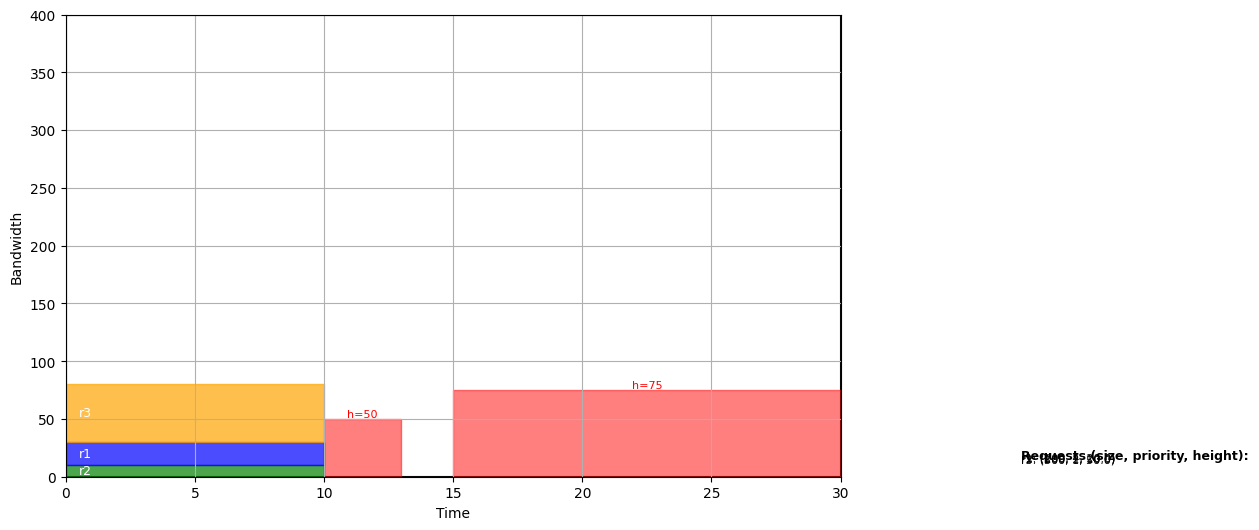


--- Request Allocation Details ---
r2 = (0, 10, 0.00, 10.00)
r1 = (0, 10, 10.00, 30.00)
r3 = (0, 10, 30.00, 80.00)
All remaining requests [(100, 2), (200, 1), (500, 3)] fitted in the 1st area


In [289]:
#visualize
slot_rects = get_next_slot(unavailable_slots, total_slots)
slot_areas = compute_slot_areas(slot_rects)

result_texts, allocations, waste_rects, total_available_area, total_r_area = find_r_slot_with_allocation(request_areas, slot_areas, slot_rects)

fig, ax = plt.subplots(figsize=(10, 6))

# total area
for x1, x2, h in total_slots:
    ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, fill=False, edgecolor='black', linewidth=1.5))

# unavailable slots
for x1, x2, h in unavailable_slots:
    ax.add_patch(patches.Rectangle((x1, 0), x2 - x1, h, color='red', alpha=0.5, label="unavailable"))
    ax.text((x1 + x2) / 2, h + 0.2, f"h={h}", ha='center', va='bottom', fontsize=8, color='red')


# results
colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
for x1, x2, y1, y2, rid in allocations:
    color = colors[(rid - 1) % len(colors)]
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, color=color, alpha=0.7))
    ax.text(x1 + 0.5, (y1 + y2) / 2, f"r{rid}", fontsize=9, va='center', ha='left', color='white')


info_x = 37
info_y = 15
dy = 1.0

ax.text(info_x, info_y, "Requests (size, priority, height):", fontsize=9, weight='bold')
info_y -= dy

rid_to_height = {}
for x1, x2, y1, y2, rid in allocations:
    height = y2 - y1
    rid_to_height[rid] = height

for i, (size, priority) in enumerate(request_r, 1):
    height = f"{rid_to_height.get(i, '-'):.1f}" if i in rid_to_height else "-"
    ax.text(info_x, info_y, f"r{i}: ({size}, {priority}, {height})", fontsize=8)
    info_y -= dy

total_slot = list(total_slots)[0]
ax.set_xlim(0, total_slot[1])
ax.set_ylim(0, total_slot[2])
ax.set_xlabel("Time")
ax.set_ylabel("Bandwidth")
plt.grid(True)
plt.show()


print("\n--- Request Allocation Details ---")

for x1, x2, y1, y2, rid in allocations:
    print(f"r{rid} = ({x1}, {x2}, {y1:.2f}, {y2:.2f})")
#print(total_available_area)
#print(total_r_area)
if total_available_area < total_r_area:
    print("need to extend space")
for line in result_texts:
    print(line)